# context

Notebook is code for analyzing the MRF and comparative analysis for the [2Y69 heterodimer](https://www.rcsb.org/structure/2y69) for a group project for the 2022 Spring Semester course Computational Genomics (CBMF W4761) at Columbia University.

- [Dylan Marshall](dmm2269@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Julia Urban](jau2112@cumc.columbia.edu), Columbia Systems Biology PhD student
- [Peiwen Cai](pc2976@cumc.columbia.edu), Columbia Systems Biology PhD student

# set up

In [30]:
%%capture
!pip install biopandas

In [31]:
from biopandas.pdb import PandasPdb
from functools import reduce
import gc, pickle
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd
from sklearn.metrics import pairwise_distances

In [2]:
# tf
%tensorflow_version 1.x
import tensorflow as tf
tfk = tf.keras
tfki = tf.keras.initializers
tfkl = tf.keras.layers
tfkm = tf.keras.models
tfko = tf.keras.optimizers
tfkr = tf.keras.regularizers
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.keras.metrics import categorical_crossentropy as CCE
import tensorflow.keras.backend as K

TensorFlow 1.x selected.


# methods

**collation**

In [3]:
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a, n in zip(alphabet, range(states)):
  a2n[a] = n

In [4]:
def aa2num(aa):
  """convert aa into num"""
  if aa in a2n: return a2n[aa]
  else: return a2n["-"]

In [5]:
def get_eff(X, thresh=0.8):
  """compute effective weight for each sequence"""
  L = X.shape[1]
  # pairwise identity
  X_pid = 1.0-squareform(pdist(X, "hamming"))
  # weight for each sequence
  W = (X_pid >= thresh).astype(float)
  W = 1/np.sum(W, -1)
  return W

In [6]:
def mk_msa(seqs):
  """converts list of sequences to msa and msa weights"""
  X = []
  for seq in seqs:
    X.append([aa2num(aa) for aa in seq])
  X = np.array(X)
  # per-sequence effective weight
  W = get_eff(X, 0.8)
  return np.eye(21)[X], W

**modeling**

In [7]:
def mrf(X, W, l2):
  """Markov Random Field"""

  def _loss(p, q):
    """pseudo-likelihood"""
    return K.sum(K.categorical_crossentropy(p, q), -1)

  def _cst_w(w):
    """constrain pairwise weights: symmetrize, set diagonal to zero"""
    w = (w+K.transpose(w))/2
    rm_I = K.constant((1-np.eye(L))[:, None, :, None], dtype=tf.float32)
    return K.reshape(K.reshape(w, (L, A, L, A))*rm_I, (L*A, L*A))

  # clear graph, define parameters
  K.clear_session()
  N, L, A = X.shape
  P = {
    "units": L*A,
    "kernel_regularizer": tfkr.l2(l2*L*A/N),
    "kernel_constraint": _cst_w
  }
  # model
  M = tfk.Sequential()
  M.add(tfkl.Flatten(input_shape=(L, A)))
  M.add(tfkl.Dense(**P))
  M.add(tfkl.Reshape((L, A)))
  M.add(tfkl.Activation("softmax"))
  
  # compile
  M.compile("adam", _loss)
  return M

In [8]:
def pw_l2(pw):
  """pw (L, A, L, A) to L2 norm form (L, L), both raw and APC"""
  # norm, remove self connection
  l2_norm = np.sqrt(np.square(pw[:, :20, :, :20]).sum((1, 3)))
  np.fill_diagonal(l2_norm, 0.0)
  # average product (~largest eigenvector)
  ap = l2_norm.sum(0)
  ap = ap[None, :]*ap[:, None]/ap.sum() 
  # remove average product
  l2_norm_apc = l2_norm-ap
  np.fill_diagonal(l2_norm_apc, 0.0)
  return l2_norm, l2_norm_apc

# analysis

**sequences from PDB / UniProt**

In [9]:
cA = "MTENNRLSVKLPGLDLKNPIIPASGCFGFGEEYAKYYDLNKLGSIMVKATTLHPRFGNPTPRVAETASGMLNAIGLQNPGLEVIMTEKLPWLNENFPELPIIANVAGSEEADYVAVCAKIGDAANVKAIELNISCPNVKHGGQAFGTDPEVAAALVKACKAVSKVPLYVKLSPNVTDIVPIAKAVEAAGADGLTMINTLMGVRFDLKTRQPILANITGGLSGPAIKPVALKLIHQVAQVVDIPIIGMGGVANAQDVLEMYMAGASAVAVGTANFADPFVCPKIIDKLPELMDQYRIESLESLIQEVKEGKK"
cB = "MSQLQEMMTVVSQREVAYNIFEMVLKGTLVDEMDLPGQFLHLAVPNGAMLLRRPISISSWDKRAKTCTILYRIGDETTGTYKLSKLESGAKVDVMGPLGNGFPVAEVTSTDKILIIGGGIGVPPLYELAKQLEKTGCQMTILLGFASENVKILENEFSNLKNVTLKIATDDGSYGTKGHVGMLMNEIDFEVDALYTCGAPAMLKAVAKKYDQLERLYISMESRMACGIGACYACVEHDKEDESHALKVCEDGPVFLGKQLSL"

**`msa.pickle`** from AlphaFold2 run

In [11]:
# data
msa = np.load("msa.pickle", allow_pickle=True)["msas"][0]
X, W = mk_msa(msa)

In [12]:
# msa dimensions
N, L, A = X.shape

In [13]:
# define, fit
m = mrf(X, W, 0.04)
m.fit(X, X, N, 256, 0, sample_weight=W);

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# coevolving positions
coevo = pw_l2(m.get_weights()[0].reshape((L, 21, L, 21)))

# top interface coevo

In [15]:
def top_coevo(ci, lenA, _5A, _10A):
  # top interface coevo pairs
  interface = ci[:lenA, lenA:]
  i5 = np.sort(interface.flatten())[::-1][_5A.shape[0]]
  i10 = np.sort(interface.flatten())[::-1][_10A.shape[0]]
  # top coevolving residue pairs
  top_i5 = np.argwhere(interface > i5)
  top_i10 = np.argwhere(interface > i10)
  return interface, top_i5, top_i10

In [16]:
def inter2list(i): return "["+", ".join(["["+i+", "+j+"]" for i, j in zip(*i.astype("str").T)])+"]"

In [17]:
#@markdown experimental 5 Å
_5A = np.array([[28, 230], [67, 48], [68, 48], [274, 226]])

In [18]:
#@markdown experimental 10 Å
_10A = np.array([[24, 231], [25, 230], [25, 231], [25, 232], [26, 225], [26, 226], [26, 230], [26, 231], [26, 232], [27, 226], [27, 229], [27, 230], [27, 231], [28, 229], [28, 230], [28, 231], [28, 232], [29, 230], [29, 231], [30, 230], [31, 228], [31, 229], [31, 230], [32, 226], [32, 227], [32, 228], [32, 229], [32, 230], [32, 231], [32, 250], [33, 226], [33, 228], [33, 229], [33, 230], [35, 4], [35, 228], [36, 2], [36, 3], [36, 4], [36, 5], [37, 2], [48, 230], [48, 231], [54, 243], [55, 243], [56, 232], [56, 235], [56, 236], [56, 237], [56, 242], [56, 243], [56, 244], [56, 245], [57, 232], [57, 233], [57, 235], [57, 245], [58, 233], [58, 235], [59, 233], [59, 235], [59, 236], [59, 237], [60, 222], [60, 223], [60, 233], [60, 234], [60, 235], [60, 236], [61, 222], [61, 223], [61, 224], [61, 233], [61, 234], [61, 235], [62, 222], [62, 223], [62, 224], [62, 225], [62, 232], [62, 233], [62, 234], [62, 235], [63, 51], [63, 222], [63, 223], [63, 224], [63, 225], [63, 232], [63, 233], [63, 234], [64, 51], [64, 223], [64, 224], [64, 225], [64, 233], [65, 48], [65, 49], [65, 50], [65, 51], [65, 52], [65, 223], [65, 225], [66, 48], [66, 49], [66, 50], [66, 51], [67, 46], [67, 47], [67, 48], [67, 49], [67, 50], [68, 46], [68, 47], [68, 48], [68, 49], [68, 50], [68, 51], [69, 48], [69, 49], [69, 50], [69, 51], [70, 49], [70, 50], [70, 51], [70, 225], [71, 225], [72, 225], [72, 231], [72, 233], [73, 233], [74, 231], [74, 232], [74, 233], [74, 234], [74, 235], [75, 232], [75, 233], [76, 231], [76, 232], [77, 231], [77, 232], [77, 233], [77, 235], [77, 245], [78, 232], [78, 245], [79, 243], [79, 244], [79, 245], [213, 223], [222, 48], [222, 50], [223, 47], [223, 48], [223, 50], [224, 48], [271, 50], [271, 51], [271, 225], [271, 226], [271, 231], [272, 50], [272, 51], [272, 226], [273, 225], [273, 226], [274, 50], [274, 51], [274, 52], [274, 224], [274, 225], [274, 226], [274, 227], [274, 228], [274, 230], [274, 231], [275, 41], [275, 42], [275, 43], [275, 44], [275, 49], [275, 50], [275, 51], [275, 52], [275, 93], [275, 95], [275, 225], [275, 226], [275, 227], [276, 5], [276, 43], [276, 50], [276, 51], [276, 52], [276, 93], [276, 95], [276, 226], [277, 2], [277, 4], [277, 5], [277, 95], [277, 226], [277, 227], [277, 228], [278, 2], [278, 5]])

In [19]:
interface, top_i5, top_i10 = top_coevo(coevo[1], len(cA), _5A, _10A)

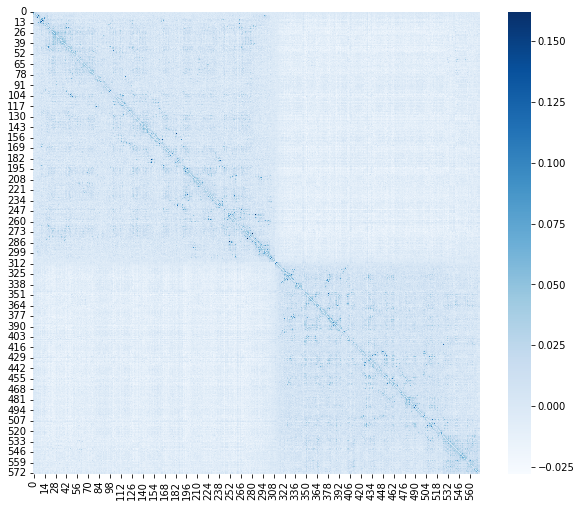

In [20]:
F, A = plt.subplots(1, 1, figsize=(10, 8.5))
sns.heatmap(coevo[1], cmap="Blues", ax=A)
plt.show();

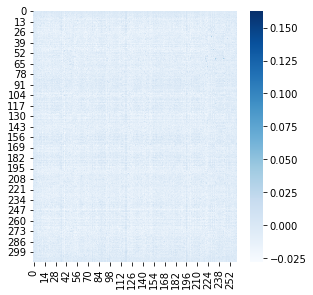

In [ ]:
figsize = (10*interface.shape[1]/L, 8.5*interface.shape[0]/L)
F, A = plt.subplots(1, 1, figsize=figsize)
sns.heatmap(interface, vmin=coevo[1].min(), vmax=coevo[1].max(), cmap="Blues", ax=A)
plt.show();

# subsampled coevo

In [21]:
idx = np.arange(len(X))
_N = int(len(X)*0.5)
subs = {s: {"coevo": None, "5A": None, "10A": None} for s in range(17)}
subs[0]["coevo"] = coevo[1]
subs[0]["5A"] = top_i5
subs[0]["10A"] = top_i10

In [22]:
%%time
for s in range(1, 17):
  print(s)
  # reset hardware
  try: del m
  except: pass
  gc.collect()
  # subsample
  np.random.shuffle(idx)
  _X = X[idx[:_N], ...]
  _W = get_eff(_X.argmax(-1))
  # define, fit
  m = mrf(_X, _W, 0.04)
  m.fit(_X, _X, _N, 256, 0, sample_weight=_W)
  # coevo for "s" interface
  ci = pw_l2(m.get_weights()[0].reshape((L, 21, L, 21)))
  # top interface pairs
  _, top_i5, top_i10 = top_coevo(ci[1], len(cA), _5A, _10A)
  subs[s]["coevo"] = ci[1]
  subs[s]["5A"] = top_i5
  subs[s]["10A"] = top_i10

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
CPU times: user 12min, sys: 19.8 s, total: 12min 20s
Wall time: 14min 52s


# results

**5A**

In [23]:
# main
print(inter2list(top_i5))

[[59, 234], [59, 244], [62, 232], [73, 232]]


In [24]:
# subsamples
for s in range(1, 17): print(s, "\t", inter2list(subs[s]["5A"]))

1 	 [[59, 234], [59, 244], [62, 232], [73, 232]]
2 	 [[48, 231], [59, 234], [59, 244], [62, 232]]
3 	 [[59, 234], [59, 244], [62, 232], [73, 232]]
4 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
5 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
6 	 [[32, 229], [59, 234], [62, 232], [273, 224]]
7 	 [[32, 229], [48, 231], [59, 234], [62, 232]]
8 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
9 	 [[48, 231], [59, 234], [59, 244], [62, 232]]
10 	 [[48, 231], [59, 234], [59, 244], [62, 232]]
11 	 [[32, 229], [48, 231], [59, 234], [62, 232]]
12 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
13 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
14 	 [[48, 231], [59, 234], [59, 244], [62, 232]]
15 	 [[32, 229], [59, 234], [59, 244], [62, 232]]
16 	 [[59, 234], [59, 244], [62, 232], [73, 232]]


**10A**

In [25]:
# main
print(inter2list(top_i10))

[[0, 36], [0, 37], [0, 88], [0, 96], [0, 98], [0, 118], [0, 120], [0, 196], [0, 197], [0, 223], [4, 161], [6, 120], [6, 217], [10, 145], [13, 113], [13, 124], [13, 219], [16, 154], [19, 36], [19, 52], [19, 197], [21, 231], [25, 231], [25, 244], [28, 144], [32, 227], [32, 229], [35, 94], [36, 144], [40, 88], [44, 185], [44, 254], [48, 231], [49, 40], [55, 169], [57, 42], [57, 224], [57, 244], [59, 202], [59, 221], [59, 232], [59, 234], [59, 244], [59, 246], [60, 234], [61, 52], [61, 92], [61, 224], [62, 160], [62, 232], [62, 235], [63, 47], [63, 222], [67, 46], [69, 224], [70, 127], [73, 232], [76, 234], [78, 49], [78, 232], [78, 246], [78, 255], [80, 110], [84, 41], [85, 158], [87, 48], [87, 116], [87, 144], [87, 244], [88, 95], [88, 246], [90, 113], [90, 145], [90, 182], [90, 236], [91, 92], [91, 117], [91, 131], [93, 102], [100, 35], [100, 55], [100, 88], [100, 99], [100, 245], [104, 82], [105, 40], [113, 204], [114, 110], [117, 157], [118, 103], [118, 204], [119, 27], [124, 27], [12

In [26]:
# subsamples
for s in range(1, 17): print(s, "\t", inter2list(subs[s]["10A"]))

1 	 [[0, 36], [0, 37], [0, 88], [0, 96], [0, 98], [0, 118], [0, 120], [0, 183], [0, 196], [0, 197], [10, 145], [10, 255], [12, 57], [14, 17], [14, 214], [19, 120], [19, 197], [25, 231], [26, 229], [28, 144], [28, 259], [32, 227], [32, 229], [34, 249], [35, 94], [36, 144], [40, 231], [44, 96], [44, 254], [46, 241], [48, 231], [49, 40], [49, 48], [50, 42], [57, 42], [57, 224], [57, 232], [59, 202], [59, 221], [59, 232], [59, 234], [59, 244], [59, 246], [60, 135], [60, 234], [61, 42], [61, 92], [61, 224], [62, 36], [62, 104], [62, 232], [62, 259], [63, 222], [67, 46], [69, 224], [73, 232], [75, 117], [75, 198], [76, 231], [76, 234], [76, 246], [77, 0], [78, 221], [78, 232], [78, 235], [78, 246], [78, 256], [81, 11], [81, 133], [83, 26], [85, 8], [85, 63], [86, 18], [87, 144], [87, 224], [87, 235], [87, 244], [88, 95], [88, 246], [90, 145], [91, 131], [91, 174], [92, 133], [98, 231], [99, 67], [99, 231], [100, 35], [100, 39], [100, 55], [100, 166], [100, 216], [102, 144], [104, 51], [104, 

# save

In [86]:
with open("1EP3_coevo.pickle", "wb") as f:
  pickle.dump(subs, f, protocol=pickle.HIGHEST_PROTOCOL)

# analysis

In [52]:
interface, top_i5, top_i10 = top_coevo(coevo[1], len(cA), _5A, _10A)

In [53]:
def pdb2dm(pdb): return squareform(pdist(pdb[["x_coord", "y_coord", "z_coord"]].values), force="tomatrix")

In [71]:
# experiment
exp = PandasPdb().fetch_pdb("1EP3").df["ATOM"]
exp = exp[(exp["chain_id"] == "A") | (exp["chain_id"] == "B")]
exp = exp[exp["atom_name"] == "CA"]
edm = pdb2dm(exp)
len_eA = len(exp[exp["chain_id"] == "A"])
ei = edm[:len_eA, len_eA:]

In [74]:
# all indices
exp_IJ = np.array([(str(i)+"_"+str(j)) for i in exp["residue_number"] for j in exp["residue_number"]])
exp_IJ = exp_IJ.reshape((len(exp), len(exp)))
# interface indices
ei_IJ = exp_IJ[:len_eA, len_eA:]

In [77]:
# prediction
af2 = PandasPdb().read_pdb("rank_1_model_1_ptm_seed_0_relaxed.pdb").df["ATOM"]
af2 = af2[af2["atom_name"] == "CA"]
adm = pdb2dm(af2)
# predicted interface distances
ai = adm[:len(cA), len(cA):]
af2_10A = np.argwhere(ai < 10)

In [78]:
# indices of top signals, in terms of uniprot
tup_mrf = [(x+"_"+y) for x, y in zip(*(top_i10+1).T.astype("str"))]
tup_exp = [(x+"_"+y) for x, y in zip(*_10A.T.astype("str"))]
tup_af2 = [(x+"_"+y) for x, y in zip(*(af2_10A+1).T.astype("str"))]

In [79]:
# venn diagram partitioning
all3 = reduce(np.intersect1d, ([tup_mrf, tup_exp, tup_af2]))
notM = [x for x in ei_IJ.flatten() if x not in tup_mrf]
MnotEP = [m for m in tup_mrf if (m not in tup_exp) and (m not in tup_af2)]

In [81]:
# mrf signal in partitions
all3_idx = np.array([ij.split("_") for ij in all3]).T
all3_mrf = np.array([interface[int(i)-1, int(j)-1] for i, j in zip(*all3_idx)])
notM_idx = np.array([ij.split("_") for ij in notM]).T
notM_mrf = np.array([interface[int(i)-1, int(j)-1] for i, j in zip(*notM_idx)])
MnotEP_idx = np.array([ij.split("_") for ij in MnotEP]).T
MnotEP_mrf = np.array([interface[int(i)-1, int(j)-1] for i, j in zip(*MnotEP_idx)])

In [83]:
# mrf distribution check
print(stats.describe(all3_mrf.flatten()))
print(stats.describe(MnotEP_mrf.flatten()))
print(stats.describe(notM_mrf.flatten()))

DescribeResult(nobs=20, minmax=(0.00922491, 0.0379631), mean=0.019705456, variance=7.5354066e-05, skewness=0.5820466876029968, kurtosis=-0.5378296016565605)
DescribeResult(nobs=186, minmax=(0.008759748, 0.03820808), mean=0.010940692, variance=9.552175e-06, skewness=4.762020587921143, kurtosis=34.05317020580311)
DescribeResult(nobs=80968, minmax=(-0.027840193, 0.0087358495), mean=-0.007095579, variance=2.5647563e-05, skewness=0.09879190474748611, kurtosis=-0.07434701837934599)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


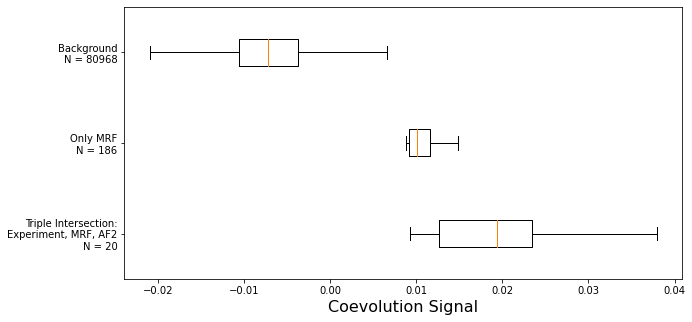

In [84]:
F, A = plt.subplots(1, 1, figsize=(10, 5))
A.boxplot([all3_mrf, MnotEP_mrf, notM_mrf], vert=False, showfliers=False)
A.set_yticklabels([
  f"Triple Intersection:\nExperiment, MRF, AF2\nN = {len(all3_mrf.flatten())}",
  f"Only MRF\nN = {len(MnotEP_mrf.flatten())}",
  f"Background\nN = {len(notM_mrf.flatten())}"
])
A.set_xlabel("Coevolution Signal", fontsize=16)
plt.show();

In [85]:
# stat sig
pq = ["MnotEP_mrf", "all3_mrf", "notM_mrf"]
for p in pq:
  for q in pq:
    if p != q:
      print(p, q, stats.mannwhitneyu(eval(p).flatten(), eval(q).flatten()))

MnotEP_mrf all3_mrf MannwhitneyuResult(statistic=631.0, pvalue=6.184412648755126e-07)
MnotEP_mrf notM_mrf MannwhitneyuResult(statistic=0.0, pvalue=2.179578587247126e-123)
all3_mrf MnotEP_mrf MannwhitneyuResult(statistic=631.0, pvalue=6.184412648755126e-07)
all3_mrf notM_mrf MannwhitneyuResult(statistic=0.0, pvalue=4.780687283387776e-15)
notM_mrf MnotEP_mrf MannwhitneyuResult(statistic=0.0, pvalue=2.179578587247126e-123)
notM_mrf all3_mrf MannwhitneyuResult(statistic=0.0, pvalue=4.780687283387776e-15)
